In [1]:
import os
import warnings
import itertools
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tqdm import tqdm
from statsmodels.tsa import stattools
from statsmodels.tools.sm_exceptions import ConvergenceWarning

os.chdir('../../data')
data = pd.read_csv('data_whole.csv').transpose()
data_gdp = pd.read_csv('../data/gdp_per_worker_worldbank.csv', index_col=0)

#カラム設定
data.columns = data.iloc[2,:]

#不要列削除、被説明変数データ結合
data.drop(['Unnamed: 0', 'Indicator Name'], axis=0, inplace=True)
data = pd.concat([data_gdp, data], axis=1)

new_index = [i if i == 'Country Name' else int(i) for i in data.index]
data.index = new_index

#欠損値部分削除(1991~2020年データに整形)
data = data.iloc[:-2]


var_list = [

#被説明変数
'productivity_swe',
'productivity_fin',
'productivity_jap',
#経済
'Trade (% of GDP)', #国の経済の開放度を示す指標。0
'Total reserves minus gold (current US$)', #国の経済的安定性を示す指標。0
'Real effective exchange rate index (2010 = 100)', #実質実効為替レート。国の競争力を示す指標。
'Self-employed, total (% of total employment) (modeled ILO estimate)',
'Unemployment, total (% of total labor force)',
#医療
'Ratio of female to male labor force participation rate (%) (modeled ILO estimate)', #男女の労働参加率の比率。健康状態や社会的要因が労働参加に与える影響を示す
'Life expectancy at birth, total (years)', #出生時の平均余命。国の医療システムの質や健康状態を示す。
'Probability of dying among youth ages 20-24 years (per 1,000)', #20-24歳の死亡率。若年労働者の健康状態やリスクを示す。
'Number of under-five deaths', # 5歳未満の死亡数は、公衆衛生や医療の質を示す指標として考えられます。
#教育
'Government expenditure on education as % of GDP (%)', #政府の教育投資割合
'Government expenditure on tertiary education, PPP$ (millions)',#tertiary educationへの政府の投資割合
#デモグラフィー
'Population growth (annual %)', #人口増加率
'Urban population (% of total population)', #都市部人口比率
'Population density (people per sq. km of land area)' #人口密度

]

data = data[var_list].transpose()

# StandardScalerのインスタンスを作成
#scaler = StandardScaler()

#sweden
df_swe = data[data['Country Name'] == 'Sweden'].transpose()
df_swe = df_swe.drop(['Country Name'], axis=0).astype(float)
df_swe.index = pd.date_range(start='1991-01-01', periods=len(df_swe), freq='Y')
df_swe = df_swe.loc[:, ~df_swe.columns.duplicated()]
# fit_transformメソッドを使用してデータを標準化し、新しいデータフレームを作成
#df_swe = pd.DataFrame(scaler.fit_transform(df_swe), columns=df_swe.columns)   
# print('Sweden descriptive statistics')
# print(df_swe.describe())
# print('~'*80)

#finland
df_fin = data[data['Country Name'] == 'Finland'].transpose()
df_fin = df_fin.drop(['Country Name'], axis=0).astype(float)
df_fin.index = pd.date_range(start='1991-01-01', periods=len(df_fin), freq='Y')
df_fin = df_fin.loc[:, ~df_fin.columns.duplicated()]
# fit_transformメソッドを使用してデータを標準化し、新しいデータフレームを作成
#df_fin = pd.DataFrame(scaler.fit_transform(df_fin), columns=df_fin.columns)
# print('Finland descriptive statistics')
# print(df_fin.describe())
# print('~'*80)

#japan
df_jap = data[data['Country Name'] == 'Japan'].transpose()
df_jap = df_jap.drop(['Country Name'], axis=0).astype(float)
df_jap.index = pd.date_range(start='1991-01-01', periods=len(df_jap), freq='Y')
df_jap = df_jap.loc[:, ~df_jap.columns.duplicated()]
# fit_transformメソッドを使用してデータを標準化し、新しいデータフレームを作成
#df_jap = pd.DataFrame(scaler.fit_transform(df_jap), columns=df_jap.columns)
# print('Japan descriptive statistics')
# print(df_jap.describe())
# print('~'*80)

df_dict = {'sweden': df_swe, 'finland': df_fin, 'japan': df_jap}

In [2]:
#1次階差データ
df_swe_diff = df_swe.diff().iloc[1:]
df_fin_diff = df_fin.diff().iloc[1:]
df_jap_diff = df_jap.diff().iloc[1:]

df_diff_dict = {'sweden':df_swe_diff, 'finland':df_fin_diff, 'japan':df_jap_diff}

In [3]:
# 説明変数のリスト

independent_variables = [

#経済
'Trade (% of GDP)', #国の経済の開放度を示す指標。
'Total reserves minus gold (current US$)', #国の経済的安定性を示す指標。
'Real effective exchange rate index (2010 = 100)', #実質実効為替レート。国の競争力を示す指標。
'Self-employed, total (% of total employment) (modeled ILO estimate)', #個人事業主の割合
'Unemployment, total (% of total labor force)', #非就労者割合
#医療
'Ratio of female to male labor force participation rate (%) (modeled ILO estimate)', #男女の労働参加率の比率。健康状態や社会的要因が労働参加に与える影響を示す
'Life expectancy at birth, total (years)', #出生時の平均余命。国の医療システムの質や健康状態を示す。
'Probability of dying among youth ages 20-24 years (per 1,000)', #20-24歳の死亡率。若年労働者の健康状態やリスクを示す。
'Number of under-five deaths', # 5歳未満の死亡数は、公衆衛生や医療の質を示す指標として考えられます。
#教育
'Government expenditure on education as % of GDP (%)', #政府の教育投資割合
'Government expenditure on tertiary education, PPP$ (millions)',#tertiary educationへの政府の投資割合
#デモグラフィー
'Population growth (annual %)', #人口増加率
'Urban population (% of total population)', #都市部人口比率
'Population density (people per sq. km of land area)' #人口密度

]

# 組み合わせのリストを生成します
combinations_of_variables = []
for r in range(1, len(independent_variables) + 1):
    combinations_of_variables.extend(
        itertools.combinations(independent_variables, r)
    )

In [4]:
country_models_diff = []

for country, df in df_diff_dict.items():

    # 警告を非表示にする
    warnings.filterwarnings("ignore")

    # 各国の最良モデル情報を格納する変数の初期化
    best_aic = float('inf')
    best_model_info = None

    # 進捗の可視化
    for combination in tqdm(combinations_of_variables, total=len(combinations_of_variables), desc=f"Fitting Models for {country}"):
        # 説明変数
        X = df[list(combination)]
        
        # 被説明変数
        y = df.iloc[:,0] 
        
        # 状態空間モデルフィット
        model = sm.tsa.UnobservedComponents(y, 'llevel', exog=X)
        
        try:
            results = model.fit()
            # AICで最良のモデルを更新
            if results.aic < best_aic:
                best_aic = results.aic
                best_model_info = {
                    'country': country,
                    'variables': combination,
                    'AIC': results.aic,
                    'BIC': results.bic,
                    'LLF': results.llf
                }
        except ValueError as e:
            # 収束しなかった場合の処理はここでは省略
            continue

    # 警告表示を元に戻す
    warnings.filterwarnings("default")

    # 最良モデルが見つかった場合、結果をcountry_modelsに追加
    if best_model_info:
        country_models_diff.append(best_model_info)

# すべての国の最良モデルの結果をデータフレームに変換
country_models_diff_df = pd.DataFrame(country_models_diff)

country_models_diff_df.to_csv('bestmodels_diff_detail.csv')

Fitting Models for japan: 100%|██████████| 16383/16383 [42:21<00:00,  6.45it/s] 


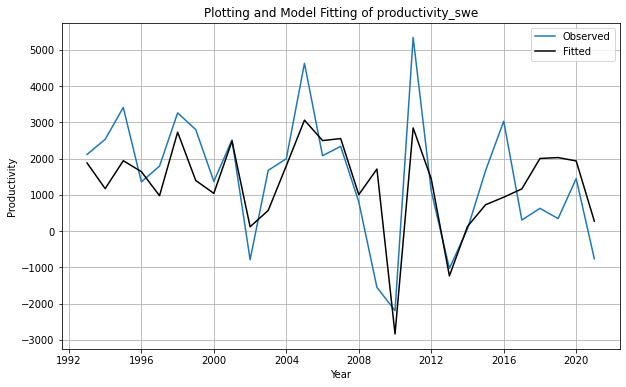

                        Unobserved Components Results                         
Dep. Variable:       productivity_swe   No. Observations:                   29
Model:                    local level   Log Likelihood                -238.801
Date:                Tue, 07 Nov 2023   AIC                            493.602
Time:                        19:54:13   BIC                            504.259
Sample:                    12-31-1992   HQIC                           496.860
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                                                                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------
sigma2.irregular                                                    1.334e+06   5.88e+05      2.26

In [15]:
#sweden
best_vars_swe = ['Trade (% of GDP)', 
                 'Real effective exchange rate index (2010 = 100)', 
                 'Unemployment, total (% of total labor force)', 
                 'Probability of dying among youth ages 20-24 years (per 1,000)', 
                 'Number of under-five deaths', 
                 'Government expenditure on education as % of GDP (%)']

y = df_swe_diff.iloc[:,0]
x = df_swe_diff[best_vars_swe]

model_swe = sm.tsa.UnobservedComponents(y, 'llevel', exog=x)

results_swe = model_swe.fit()

 # 元のデータとモデルによる予測値をプロット
plt.figure(figsize=(10, 6)) # グラフのサイズを設定
plt.plot(df_swe_diff.index, df_swe_diff['productivity_swe'], label='Observed')  # 元のデータをプロット
plt.plot(df_swe_diff.index, results_swe.fittedvalues, label='Fitted', color='k')  # フィットした値をプロット

# グラフのタイトルと軸ラベルを設定
plt.title('Plotting and Model Fitting of productivity_swe')
plt.xlabel('Year')
plt.ylabel('Productivity')

# 凡例を表示
plt.legend()

# グリッドを表示
plt.grid(True)

# グラフを表示
plt.show()

#results
print(results_swe.summary())

tables = results_swe.summary().tables
params_df = pd.DataFrame(tables[1].data[1:], columns=tables[1].data[0])

# CSVファイルに出力
params_df.to_csv('../models/model_diff_parameters_swe.csv', index=False)

In [19]:
from PIL import Image, ImageDraw, ImageFont

# 結果のサマリーを取得
summary_text = results_swe.summary().as_text()

# 画像としてサマリーを保存
def text_to_image(text, file_name):
    # テキストを挿入するための画像を作成
    # 背景は白で、サイズは適切に調整してください
    image = Image.new('RGB', (850, 450), color = (255, 255, 255))
    d = ImageDraw.Draw(image)
    
    # フォントの設定（適切なパスとサイズに調整してください）
    font = ImageFont.load_default()
    
    # テキストを画像上に配置
    d.text((10,10), text, fill=(0,0,0), font=font)
    
    # 画像をファイルに保存
    image.save(file_name)

# 画像として出力
text_to_image(summary_text, '../models/model_diff_summary_swe.png')

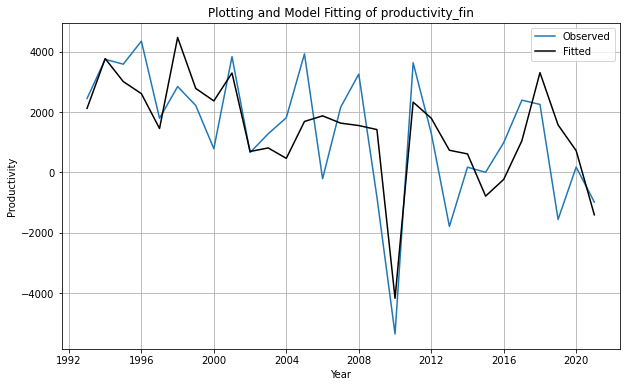

                        Unobserved Components Results                         
Dep. Variable:       productivity_fin   No. Observations:                   29
Model:                    local level   Log Likelihood                -242.598
Date:                Tue, 07 Nov 2023   AIC                            495.196
Time:                        19:55:23   BIC                            501.857
Sample:                    12-31-1992   HQIC                           497.232
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                                                                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------
sigma2.irregular                                                          1.839e+06   

In [17]:
#finland
best_vars_fin = ['Trade (% of GDP)', 
                 'Self-employed, total (% of total employment) (modeled ILO estimate)', 
                 'Number of under-five deaths']

y = df_fin_diff.iloc[:,0]
x = df_fin_diff[best_vars_fin]

model_fin = sm.tsa.UnobservedComponents(y, 'llevel', exog=x)

results_fin = model_fin.fit()

 # 元のデータとモデルによる予測値をプロット
plt.figure(figsize=(10, 6)) # グラフのサイズを設定
plt.plot(df_fin_diff.index, df_fin_diff['productivity_fin'], label='Observed')  # 元のデータをプロット
plt.plot(df_fin_diff.index, results_fin.fittedvalues, label='Fitted', color='k')  # フィットした値をプロット

# グラフのタイトルと軸ラベルを設定
plt.title('Plotting and Model Fitting of productivity_fin')
plt.xlabel('Year')
plt.ylabel('Productivity')

# 凡例を表示
plt.legend()

# グリッドを表示
plt.grid(True)

# グラフを表示
plt.show()

#results
print(results_fin.summary())

tables = results_fin.summary().tables
params_df = pd.DataFrame(tables[1].data[1:], columns=tables[1].data[0])

# CSVファイルに出力
params_df.to_csv('../models/model_diff_parameters_fin.csv', index=False)

In [20]:
from PIL import Image, ImageDraw, ImageFont

# 結果のサマリーを取得
summary_text = results_fin.summary().as_text()

# 画像としてサマリーを保存
def text_to_image(text, file_name):
    # テキストを挿入するための画像を作成
    # 背景は白で、サイズは適切に調整してください
    image = Image.new('RGB', (850, 450), color = (255, 255, 255))
    d = ImageDraw.Draw(image)
    
    # フォントの設定（適切なパスとサイズに調整してください）
    font = ImageFont.load_default()
    
    # テキストを画像上に配置
    d.text((10,10), text, fill=(0,0,0), font=font)
    
    # 画像をファイルに保存
    image.save(file_name)

# 画像として出力
text_to_image(summary_text, '../models/model_diff_summary_fin.png')

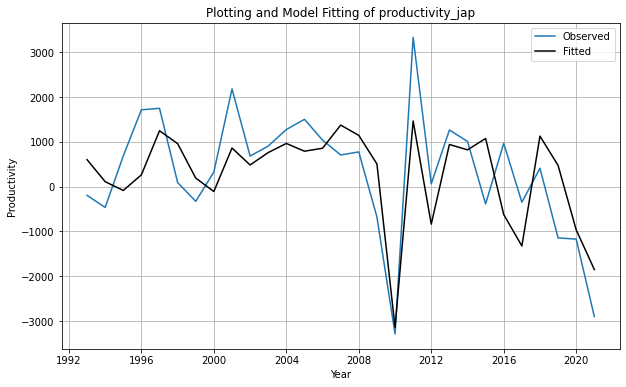

                        Unobserved Components Results                         
Dep. Variable:       productivity_jap   No. Observations:                   29
Model:                    local level   Log Likelihood                -230.777
Date:                Tue, 07 Nov 2023   AIC                            471.554
Time:                        19:55:31   BIC                            478.215
Sample:                    12-31-1992   HQIC                           473.590
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                                                                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------
sigma2.irregular                                                    7.862e+05   2.69e+05      2.92

In [18]:
#japan
best_vars_jap = ['Trade (% of GDP)', 
                 'Probability of dying among youth ages 20-24 years (per 1,000)', 
                 'Population density (people per sq. km of land area)']

y = df_jap_diff.iloc[:,0]
x = df_jap_diff[best_vars_jap]

model_jap = sm.tsa.UnobservedComponents(y, 'llevel', exog=x)

results_jap = model_jap.fit()

 # 元のデータとモデルによる予測値をプロット
plt.figure(figsize=(10, 6)) # グラフのサイズを設定
plt.plot(df_jap_diff.index, df_jap_diff['productivity_jap'], label='Observed')  # 元のデータをプロット
plt.plot(df_jap_diff.index, results_jap.fittedvalues, label='Fitted', color='k')  # フィットした値をプロット

# グラフのタイトルと軸ラベルを設定
plt.title('Plotting and Model Fitting of productivity_jap')
plt.xlabel('Year')
plt.ylabel('Productivity')

# 凡例を表示
plt.legend()

# グリッドを表示
plt.grid(True)

# グラフを表示
plt.show()

#results
print(results_jap.summary())

tables = results_jap.summary().tables
params_df = pd.DataFrame(tables[1].data[1:], columns=tables[1].data[0])

# CSVファイルに出力
params_df.to_csv('../models/model_diff_parameters_jap.csv', index=False)


In [21]:
from PIL import Image, ImageDraw, ImageFont

# 結果のサマリーを取得
summary_text = results_jap.summary().as_text()

# 画像としてサマリーを保存
def text_to_image(text, file_name):
    # テキストを挿入するための画像を作成
    # 背景は白で、サイズは適切に調整してください
    image = Image.new('RGB', (850, 450), color = (255, 255, 255))
    d = ImageDraw.Draw(image)
    
    # フォントの設定（適切なパスとサイズに調整してください）
    font = ImageFont.load_default()
    
    # テキストを画像上に配置
    d.text((10,10), text, fill=(0,0,0), font=font)
    
    # 画像をファイルに保存
    image.save(file_name)

# 画像として出力
text_to_image(summary_text, '../models/model_diff_summary_jap.png')